# CC Scheme

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import os
import xcorr

In [2]:
%matplotlib notebook

In [3]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [4]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = pd.to_timedelta((0,6),unit='h')
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        # ('remove_sensitivity', {}),
        ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
}

Inventory created at 2020-04-03T15:44:00.418917Z
	Created by: ObsPy 1.2.1
		    https://www.obspy.org
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (4):
			AU, IM, IU (2x)
		Stations (30):
			AU.NFK (Norfolk Island)
			AU.NIUE (Niue Island, Niue)
			IM.H01W1 (Cape Leeuwin Hydroacoustic Site W1, Augusta, WA, Australia)
			IM.H01W2 (Cape Leeuwin Hydroacoustic Site W2, Augusta, WA, Australia)
			IM.H01W3 (Cape Leeuwin Hydroacoustic Site W3, Augusta, WA, Australia)
			IM.H08N1 (Diego Garcia Hydroacoustic Site N1, United Kingdom)
			IM.H08N2 (Diego Garcia Hydroacoustic Site N2, United Kingdom)
			IM.H08N3 (Diego Garcia Hydroacoustic Site N3, United Kingdom)
			IM.H08S1 (Diego Garcia Hydroacoustic Site S1, United Kingdom)
			IM.H08S2 (Diego Garcia Hydroacoustic Site S2, United Kingdom)
			IM.H08S3 (Diego Garcia Hydroacoustic Site S3, United Kingdom)
			IM.H10N1 (Ascension Island Hydroacoustic Site N1, United Kingdom)
			IM.H10N2 (Ascension Iland Hydroacoustic Site N2, Unite

<IPython.core.display.Javascript object>


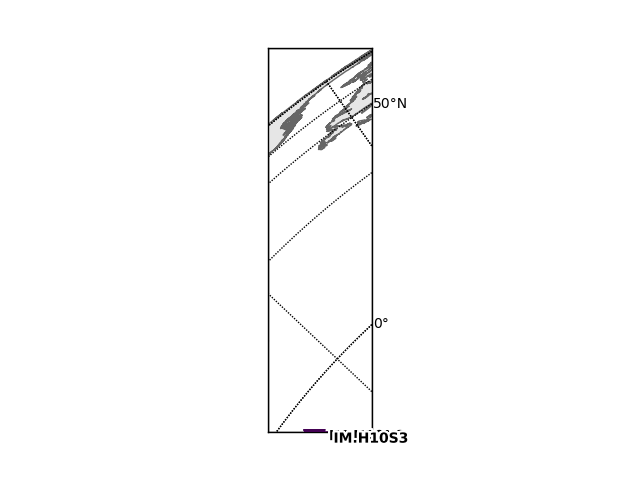

In [9]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-01-18', freq='1D')

# inv = xcorr.util.get_pair_inventory(pairs, read_inventory('../data/Monowai_new.xml'), times)
inv = read_inventory('../data/Monowai.xml')

print(inv)
fig = inv.plot(color=0., projection='local')

<IPython.core.display.Javascript object>


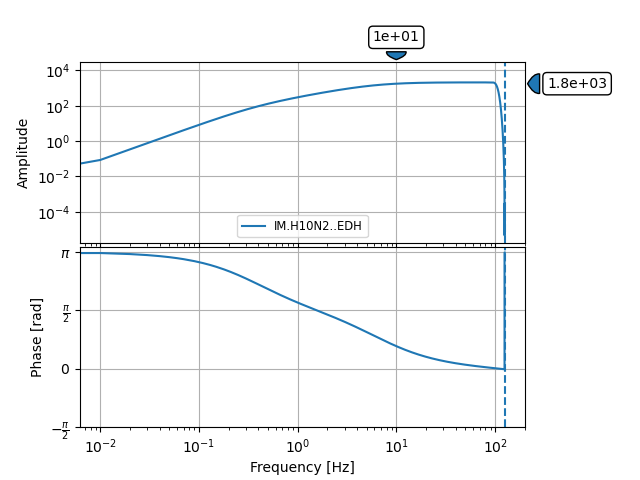

In [10]:
fig = inv.plot_response(0.01, station="H10N2")

## Correlate one day of data

In [11]:
pair = pairs[0]
time = times[0]

In [12]:
ds = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=preprocess, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

In [13]:
ds

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 1, time: 8)
Coordinates:
  * pair         (pair) object 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * time         (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 1.399e+04
    status       (pair, time) int8 0 0 0 0 0 0 0 0
    pair_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                 Monowai Volcanic Centre Crosscorrelations - 2015.015
    institution:           Delft University of Technology, Department of Geos...
    author:                Pieter Smets - P.S.M.Smets@tudelft.nl
    source:                CTBTO/IMS hydroacoustic data and IRIS/USGS seismic...
    history:               Created @ 2020-04-04 09:44:48.962442
    references:            Bendat, J. Samuel, & Piersol, A. Gerald. (1971). R...
    comment:               n/a
    Conventions:           CF-1.9
    xcorr_version:         0.1.dev109+g941d3c8.d20200403
    dependencies_version:  json-2.0.9, numpy-1.18.1, obspy-1.2.1, pandas-1.0....
    sha256_hash_metadata:  35d5d8d9e501ffd695b62aa064377a31059b2d64955e6da818...

In [15]:
xcorr.process(ds, inventory=inv, client=client)

IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T00:00:00: Has status "1". Skip.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T03:00:00: Has status "1". Skip.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T06:00:00: Has status "1". Skip.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T09:00:00: Has status "1". Skip.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T12:00:00: Has status "1". Skip.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T15:00:00: Has status "1". Skip.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T18:00:00: Waveforms. 

/Users/psmets/Documents/Research/_progs/_Python/xcorr/xcorr/preprocess/operations.py:338: UserWarning: Failed to execute operation "remove_response". Returned error: No response information found. Use `inventory` parameter to specify an inventory with response information.
  if verb > 2:


CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T21:00:00: Waveforms. CC. Done.


In [ ]:
xcorr.write(ds, 'test.nc', verb=1)

In [ ]:
ds1 = xcorr.read('test.nc', verb=1)

In [ ]:
ds1

### A whole period

In [ ]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)
dest = '/Users/psmets/Documents/Research/_studies/_hydro/monowai_remote/tests/full'

In [ ]:
warnings.filterwarnings('ignore') # no warnings of duplicate inventory items

for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = os.path.join(dest,pair,filename(pair, time))
        ds = False
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if ds and np.all(ds.status.values == 1):
                ds.close()
                continue
        if not ds:
            ds = xcorr.init_dataset(
                pair=pair,
                starttime=time,
                endtime=time + pd.offsets.DateOffset(1), 
                attrs=attrs,
                preprocess=preprocess, 
                sampling_rate=sampling_rate, 
                window_length=window_length, 
                window_overlap=window_overlap, 
                clip_lag=clip_lag,
                unbiased_cc=False,
                inventory=inv,
                stationary_poi=poi,
            )
        try:
            xcorr.cc_dataset(
                ds,
                inventory=inv.select(
                    starttime=UTCDateTime(time),
                    endtime=UTCDateTime(time + pd.offsets.DateOffset(1))
                ),
                client=client,
                retry_missing=True,
            )
        except (KeyboardInterrupt, SystemExit):
            raise
        except Exception as e:
            print('An error occurred. Save and continue next timestep or pair.')
            print('Error:')
            print(e)
        if ds and np.any(ds.status.values != 0):
            xcorr.write_dataset(ds,ncfile)